In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp
from statsmodels.distributions.empirical_distribution import ECDF
import statsmodels.distributions.empirical_distribution as edf
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [4]:
#Preprocess the data
data = np.genfromtxt("Train.csv",delimiter=',')
data = data[1:len(data)]
data = data[:,3:14]
Y = data[:,0]
X = data[:,1:10]

d3 = np.argwhere(np.isnan(Y))
X = np.delete(X,d3,axis=0)
Y = np.delete(Y,d3,axis=0)

d2 = np.argwhere(np.isnan(X))
X = np.delete(X,d2,axis=0)
Y = np.delete(Y,d2,axis=0)

Y[Y<0]=0
d = np.where(Y == 0)
X_train = np.delete(X,d[0],axis=0)
Y_train = np.delete(Y,d[0],axis=0)

Max_X = []
for i in range(len(X_train[0])):
  Max_X.append(X_train[:,i].max())
Max_Y =   Y_train.max()
test = np.genfromtxt("Test.csv",delimiter=',')
test = test[1:len(test)]
test = test[:,3:15]
Y_test = test[:,0]
X_test = test[:,1:10]
index = test[:,10]

d3 = np.argwhere(np.isnan(Y_test))
X_test = np.delete(X_test,d3,axis=0)
Y_test = np.delete(Y_test,d3,axis=0)
index = np.delete(index,d3,axis=0)

d2 = np.argwhere(np.isnan(X_test))
X_test = np.delete(X_test,d2,axis=0)
Y_test = np.delete(Y_test,d2,axis=0)
index = np.delete(index,d2,axis=0)

Y_test[Y_test<0]=0
d = np.where(Y_test == 0)
X_test = np.delete(X_test,d[0],axis=0)
Y_test = np.delete(Y_test,d[0],axis=0)
index = np.delete(index,d[0],axis=0)

In [5]:
for i in range(len(X_test[0])):
  X_test[:,i] = X_test[:,i]/Max_X[i]
y_test = Y_test/Max_Y

for i in range(len(X_train[0])):
  X_train[:,i] = X_train[:,i]/Max_X[i]
y_train = Y_train/Max_Y

In [6]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Reshape the input for LSTM
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [7]:
# Create and train the neural network model
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = LSTM(64, activation='relu', return_sequences=True)(inputs)
x = LSTM(128, activation='relu', return_sequences=True)(inputs)
x = LSTM(64, activation='relu')(x)
dense = Dense(32, activation='relu')(x)
loc = Dense(1, activation='linear')(dense)
scale = Dense(1, activation='softplus')(dense)
dist = tfp.layers.DistributionLambda(lambda params: tfp.distributions.Normal(loc=params[0], scale=params[1]))([loc, scale])

model = Model(inputs, dist)

model.compile(optimizer=Adam(learning_rate=0.001), loss=lambda y_true, y_pred: -y_pred.log_prob(y_true))

model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.1)

Epoch 1/500
267/267 [==============================] - 5s 7ms/step - loss: -0.0128 - val_loss: -0.5083
Epoch 2/500
267/267 [==============================] - 2s 6ms/step - loss: -0.4301 - val_loss: -0.5670
Epoch 3/500
267/267 [==============================] - 2s 6ms/step - loss: -0.5060 - val_loss: -0.7140
Epoch 4/500
267/267 [==============================] - 2s 6ms/step - loss: -0.5249 - val_loss: -0.9424
Epoch 5/500
267/267 [==============================] - 3s 9ms/step - loss: -0.5571 - val_loss: -0.8606
Epoch 6/500
267/267 [==============================] - 2s 6ms/step - loss: -0.5737 - val_loss: -0.8571
Epoch 7/500
267/267 [==============================] - 1s 6ms/step - loss: -0.5710 - val_loss: -0.9737
Epoch 8/500
267/267 [==============================] - 2s 6ms/step - loss: -0.5935 - val_loss: -0.7929
Epoch 9/500
267/267 [==============================] - 2s 6ms/step - loss: -0.6171 - val_loss: -1.1750
Epoch 10/500
267/267 [==============================] - 2s 6ms/step - los

In [9]:
# Make initial predictions
y_pred_dist = model(X_test)
y_pred_mean = y_pred_dist.mean().numpy()
y_pred_std = y_pred_dist.stddev().numpy()

In [12]:
def ProbForecast(results, percent):
   ecdf = ECDF(results)
   slope_changes = sorted(set(results))
   sample_edf_values_at_slope_changes = [ ecdf(item) for item in slope_changes]
   inverted_edf = interp1d(sample_edf_values_at_slope_changes, slope_changes,axis=0, fill_value="extrapolate")
   return (inverted_edf(percent))

In [13]:
# Make probabilistic predictions
Prob_results=[]
for i in range(len(y_test)):
  Prob_results.append(np.random.normal(y_pred_mean[i], y_pred_std[i], size=300) )
  
Prob_resultss = [[] for i in range(9)]
for i in range(9):
  for j in range(len(Y_test)):
     if np.isnan(ProbForecast(Prob_results[j], 0.1*(i+1))):
        print("**")
        Prob_resultss[i].append(Prob_results[j][0])       
     else:
        Prob_resultss[i].append(ProbForecast(Prob_results[j], 0.1*(i+1)))
Prob_resultss = [[0 if x < 0 else x for x in sublist] for sublist in Prob_resultss]
Prob_resultss = np.array(Prob_resultss)
Prob_resultss = Prob_resultss *Max_Y
Y_test = Y_test*Max_Y
y_pred_mean= y_pred_mean*Max_Y

In [41]:
start = 340
end = 370

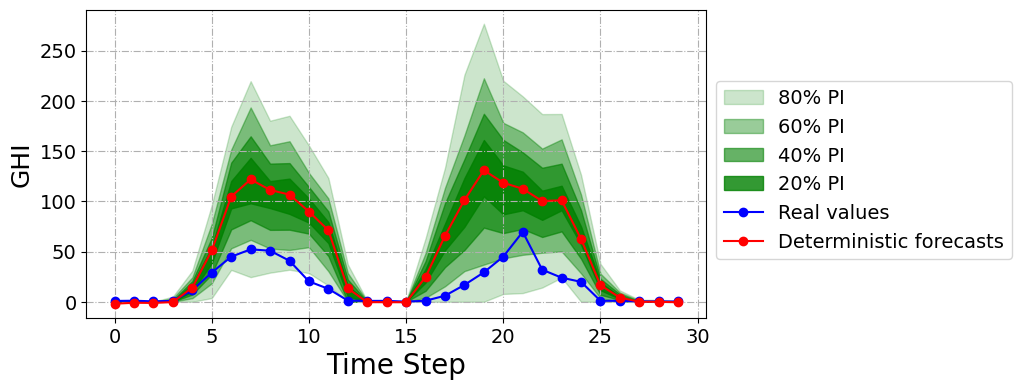

In [42]:
#Plot part of the forecasts
t = np.arange(0, end-start, 1)
plt.figure(figsize=(8,4))
plt.fill_between(t, Prob_resultss[0][start:end],Prob_resultss[8][start:end],color='green',alpha=0.2,label='80% PI')
plt.fill_between(t, Prob_resultss[1][start:end],Prob_resultss[7][start:end],color='green',alpha=0.4,label='60% PI')
plt.fill_between(t, Prob_resultss[2][start:end],Prob_resultss[6][start:end],color='green',alpha=0.6,label='40% PI')
plt.fill_between(t, Prob_resultss[3][start:end],Prob_resultss[5][start:end],color='green',alpha=0.8,label='20% PI')
plt.plot(Y_test[start:end],'bo-',label='Real values')
plt.plot(y_pred_mean[start:end],'ro-',label='Deterministic forecasts')
x=np.arange(16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14) 
plt.xlabel('Time Step', fontsize = 20)
plt.ylabel('GHI', fontsize = 18)
plt.grid(linestyle='-.')
plt.legend(bbox_to_anchor=(1,0.8), loc='upper left', fontsize = 14)
plt.savefig('Seattle Case.png', bbox_inches = 'tight')